# Notebook: Convert to Formatted JSON

## Packages

In [1]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../03 dataset split/'))
from format_labelstudio_json import format_json

In [2]:
sys.path.append(os.path.abspath('../07 train classifier/'))
from TASD.evaluation import calculate_metrics_for_examples
import constants

In [3]:
import pandas as pd
import json

## Settings

In [4]:
MODEL = "Llama13B"
FEW_SHOT = "random"
N_EXAMPLES = 25

## Code

In [5]:
with open(f"annotation_datasets/synth_annotation_labelstudio_output/annotation_{MODEL}_{FEW_SHOT}_{N_EXAMPLES}.json", 'r') as json_file:
    synthetic_data = json.load(json_file)    

In [6]:
synth_llm_labels = []
for split_id in range(5):
    with open(f"../07 train classifier/synth/{MODEL}/{FEW_SHOT}/split_{split_id}.json", 'r') as json_file:
       synthetic_data_split = json.load(json_file)
       for example in  synthetic_data_split:
           synth_llm_labels.append(example)    

In [7]:
# ground truth - annotations
synth_annotated = format_json(synthetic_data)
synth_annotated_ids = [example["id"] for example in synth_annotated]

# label from llm
synth_llm_labels = [example for example in synth_llm_labels if example["id"] in synth_annotated_ids]
def get_index(example):
    return synth_annotated_ids.index(example["id"])
synth_llm_labels = sorted(synth_llm_labels, key=get_index)

In [8]:
len(synth_llm_labels)

25

In [9]:
synth_annotated[1]["tags"], synth_annotated[1]["text"]

([], 'Ja, das ist sicher eine Nostalgie für uns.')

In [10]:
synth_llm_labels[1]["tags"], synth_llm_labels[1]["text"]

([{'text': 'Nostalgie',
   'start': 24,
   'end': 33,
   'tag_with_polarity': 'GENERAL-IMPRESSION-POSITIVE',
   'tag_with_polarity_and_type': 'GENERAL-IMPRESSION-POSITIVE-explicit',
   'type': 'label-explicit',
   'label': 'GENERAL-IMPRESSION',
   'polarity': 'POSITIVE'}],
 'Ja, das ist sicher eine Nostalgie für uns.')

In [11]:
synth_llm_labels = [[{"aspect_category": tag["label"], "aspect_polarity": tag["polarity"], "aspect_term": tag["text"]} for tag in example["tags"]] for example in synth_llm_labels]
synth_annotated = [[{"aspect_category": tag["label"], "aspect_polarity": tag["polarity"], "aspect_term": tag["text"] if tag["text"] != 'NULL' else None} for tag in example["tags"]] for example in synth_annotated]

## Test: Check how many Triplets could be identified

In [12]:
calculate_metrics_for_examples(synth_annotated, synth_llm_labels)

{'f1': 0.4193548387096774,
 'recall': 0.5416666666666666,
 'precision': 0.34210526315789475,
 'accuracy': 0.2653061224489796,
 'tp': 13,
 'tn': 0,
 'fp': 25,
 'fn': 11}

## Test: Compare aspect category annotations

In [14]:
def category_list_to_label(cat_list):
    return [1 if cat in cat_list else 0 for cat in constants.ASPECT_CATEGORIES]

In [15]:
synth_llm_labels_categories = [category_list_to_label([tag["aspect_category"] for tag in example]) for example in synth_llm_labels]
synth_annotated_categories = [category_list_to_label([tag["aspect_category"] for tag in example]) for example in synth_annotated]

In [16]:
true_classes = synth_annotated_categories
predicted_classes = synth_llm_labels_categories

accuracy = accuracy_score(true_classes, predicted_classes)
# Accuracy ist korrekt, wenn alle fünf klassen eines Beispiels korrekt predicted wurden
print(f'Accuracy: {accuracy}')

confusion = multilabel_confusion_matrix(true_classes, predicted_classes)


Accuracy: 0.56


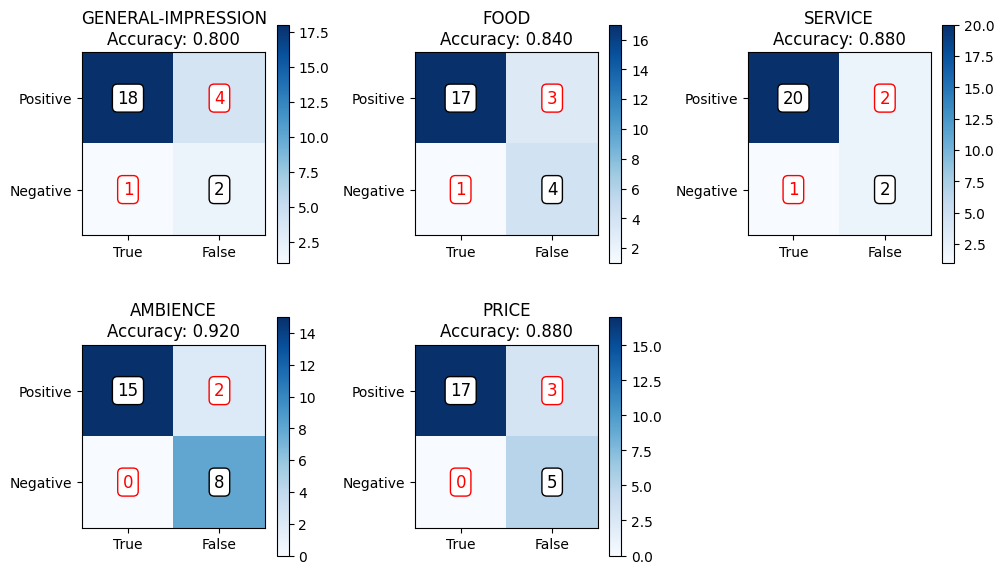

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import accuracy_score

plt.figure(figsize=(10, 6))

for i, cls in enumerate(constants.ASPECT_CATEGORIES):
    plt.subplot(2, 3, i + 1)
    conf_matrix = confusion[i]
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{cls}\nAccuracy: {(conf_matrix[0][0] + conf_matrix[1][1]) / len(predicted_classes):.3f}')
    plt.colorbar()

    for j in range(2):
        for k in range(2):
            cell_text = str(conf_matrix[j, k])
            cell_color = 'red' if j != k else 'black'
            cell_bbox = dict(boxstyle='round', facecolor='white', edgecolor=cell_color)
            plt.text(k, j, cell_text, horizontalalignment='center', verticalalignment='center', fontsize=12, color=cell_color, bbox=cell_bbox)

    plt.xticks([0, 1], ['True', 'False'])
    plt.yticks([0, 1], ['Positive', 'Negative'])

plt.tight_layout()
plt.show()


